In [1]:
!pip install wget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from subprocess import call
from scipy.stats.distributions import gamma,lognorm
import json 
import wget
import os
import os.path
from google.colab import drive
# os.chdir('/content/gdrive/My Drive')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
def n2z(x):
    x[np.logical_or(np.isnan(x),np.isinf(x))] = 0
    return x

if os.path.exists(os.getcwd()+"\\national.json"):
    os.remove(os.getcwd()+"\\national.json")
wget.download('https://api.covid19india.org/data.json', os.getcwd()+"//national.json")

if os.path.exists(os.getcwd()+"\\states.json"):
    os.remove(os.getcwd()+"\\states.json")
wget.download('https://api.covid19india.org/states_daily.json', os.getcwd()+"//states.json")

if os.path.exists(os.getcwd()+"\\test.json"):
    os.remove(os.getcwd()+"\\test.json")
wget.download('https://api.covid19india.org/state_test_data.json', os.getcwd()+"//test.json")

'/content//test (1).json'

In [0]:
def fn(mon):
  if(mon == "01"):
    return " January"
  if(mon == "02"):
    return " February"
  if(mon == "03"):
    return " March"
  if(mon == "04"):
    return " April"
  if(mon == "05"):
    return " May"
  if(mon == "06"):
    return " June"
  if(mon == "07"):
    return " July"
  if(mon == "08"):
    return " August"
  if(mon == "09"):
    return " September"
  if(mon == "10"):
    return " October"
  if(mon == "11"):
    return " November"
  if(mon == "12"):
    return " December"
def convert(dat): 
    return  str(dat[:2]) + fn(str(dat[3:5]))

In [0]:
dates = np.array([pd.to_datetime(i['date']+"2020") for i in json.load(open('national.json',))['cases_time_series']])
confirmed = np.array([int(i['dailyconfirmed'])for i in json.load(open('national.json',))['cases_time_series']])
deceased = np.array([int(i['dailydeceased'])for i in json.load(open('national.json',))['cases_time_series']])
recovered = np.array([int(i['dailyrecovered'])for i in json.load(open('national.json',))['cases_time_series']])

confirmed = confirmed[dates>=pd.to_datetime("03/04/20")]
deceased = deceased[dates>=pd.to_datetime("03/04/20")]
recovered = recovered[dates>=pd.to_datetime("03/04/20")]
dates = dates[dates>=pd.to_datetime("03/04/20")]

In [6]:
conf = []

for n in range(100):
    print("Iteration: ",n+1,end='\r')
    dataset = np.copy(confirmed)
    mean = 13.0+(20.9-8.7)/4*np.random.normal()
    sd = 12.7+(26.0-6.4)/4*np.random.normal()
    phi = np.sqrt(sd**2 + mean**2)
    mu = np.log(mean**2/phi)
    sigma = np.sqrt(np.log(phi**2/mean**2))
    L = lognorm(s=sigma,scale=np.exp(mu))
    for i in range(len(dataset)-1,-1,-1):
        send_forward = np.round(L.rvs(dataset[i]))
        send_forward = send_forward[i+send_forward<len(dataset)]
        dataset[i] = 0
        for j in np.unique(np.int32(send_forward)):
            dataset[i+j] += np.sum(send_forward==j)
    conf.append(dataset)

In [7]:
CFR = np.cumsum(deceased)/np.cumsum(conf,axis=1)
col_mean = np.nanmean(CFR, axis=0)
inds = np.where(np.isnan(CFR))
CFR[inds] = np.take(col_mean, inds[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [0]:
temp=dates
dates=[]
for i in range(len(temp)):
  date=[]
  t=(str(temp[i])).split()[0]
  m=t[5:7]
  d=t[-2:]
  #print(m,t)
  date.append(d)
  date.append('/')
  date.append(m)
  date=''.join([str(elem) for elem in date])
  #print(date)
  dates.append(convert(date))

In [9]:
json_data = {}
india = {
        'dates':dates,
        'cfr1_point':list(n2z(np.cumsum(deceased)/np.cumsum(confirmed))),
        'cfr2_point':list(n2z(np.cumsum(deceased)/(np.cumsum(deceased)+np.cumsum(recovered)))),
        'cfr3_point':list(n2z(np.mean(CFR,axis=0))),
        'cfr3_l95':list(n2z(np.quantile(CFR,0.025,axis=0))),
        'cfr3_u95':list(n2z(np.quantile(CFR,0.975,axis=0))),
        'cfr3_l50':list(n2z(np.quantile(CFR,0.25,axis=0))),
        'cfr3_u50':list(n2z(np.quantile(CFR,0.75,axis=0))),
        }
json_data['India'] = india

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [0]:
states = list(filter(lambda v:len(v)<3,list(json.load(open('states.json',))['states_daily'][0].keys())))

In [0]:
dates = np.array([pd.to_datetime(i['date']) for i in filter(lambda v: v['status'] == 'Confirmed',json.load(open('states.json',))['states_daily'])])
#print(dates)
data_recovered = pd.DataFrame()
data_deceased = pd.DataFrame()
data_confirmed = pd.DataFrame()
for st in states:
    data_confirmed[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Confirmed',json.load(open('states.json',))['states_daily'])])
    data_deceased[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Deceased',json.load(open('states.json',))['states_daily'])])
    data_recovered[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Recovered',json.load(open('states.json',))['states_daily'])])

In [0]:
data_recovered = data_recovered.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_recovered = data_recovered.astype(np.int32)
data_confirmed = data_confirmed.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_confirmed = data_confirmed.astype(np.int32)
data_deceased = data_deceased.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_deceased = data_deceased.astype(np.int32)
data_deceased['date'] = dates
data_recovered['date'] = dates
data_confirmed['date'] = dates

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


Iteration: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


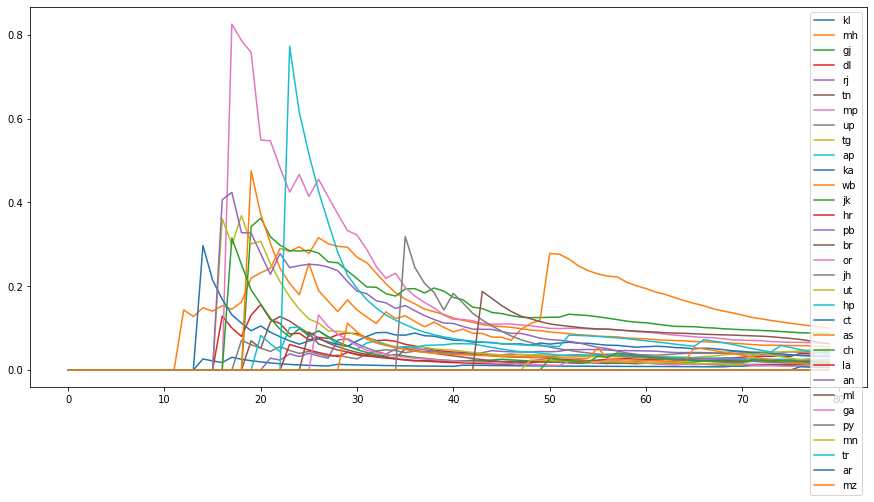

In [13]:
plt.figure(1, figsize=(15, 7))
state_id = {
  "kl":"Kerala",
  "mh":"Maharashtra",
  "gj":"Gujarat",
  "dl":"Delhi",
  "rj":"Rajasthan",
  "tn":"Tamil Nadu",
  "mp":"Madhya Pradesh",
  "up":"Uttar Pradesh",
  "tg":"Telangana",
  "ap":"Andhra Pradesh",
  "ka":"Karnataka",
  "wb":"West Bengal",
  "jk":"Jammu and Kashmir",
  "hr":"Haryana",
  "pb":"Punjab",
  "br":"Bihar",
  "or":"Odisha",
  "jh":"Jharkand",
  "ut":"Uttarakhand",
  "hp":"Himachal Pradesh",
  "ct":"Chhattisgarh",
  "as":"Assam",
  "ch":"Chandigarh",
  "la":"Ladakh",
  "an":"Andaman and Nicobar Islands",
  "ml":"Meghalaya",
  "ga":"Goa",
  "py":"Puducherry",
  "mn":"Manipur",
  "tr":"Tripura",
  "ar":"Arunachal Pradesh",
  "mz":"Mizoram" ,
}

for state in state_id.keys():
    boots = 100
    conf = []
    for n in range(boots):
        print("Iteration: ",n+1,end='\r')
        dataset = np.copy(data_confirmed[state].values)
        mean = 13.0+(20.9-8.7)/4*np.random.normal()
        sd = 12.7+(26.0-6.4)/4*np.random.normal()
        phi = np.sqrt(sd**2 + mean**2)
        mu = np.log(mean**2/phi)
        sigma = np.sqrt(np.log(phi**2/mean**2))
        L = lognorm(s=sigma,scale=np.exp(mu))
        for i in range(len(dataset)-1,-1,-1):
            send_forward = np.round(L.rvs(np.max([dataset[i],0])))
            send_forward = send_forward[i+send_forward<len(dataset)]
            dataset[i] = 0
            for j in np.unique(np.int32(send_forward)):
                dataset[i+j] += np.sum(send_forward==j)
        conf.append(dataset)
    CFR = np.cumsum(data_deceased[state].values)/np.cumsum(conf,axis=1)
    col_mean = np.nanmean(CFR, axis=0)
    inds = np.where(np.isnan(CFR))
    CFR[inds] = np.take(col_mean, inds[1])
    temp1=list(pd.Series(dates).dt.strftime('%m-%d-%Y'))
    #print(temp1[0])
    dates1=[]
    for i in range(len(temp1)):
      date=temp1[i][3:5]+'/'+temp1[i][0:2]
      dates1.append(convert(date))
    temp = {
        'dates':dates1,
        'cfr1_point':list(n2z(np.cumsum(data_deceased[state].values)/np.cumsum(data_confirmed[state].values))),
        'cfr2_point':list(n2z(np.cumsum(data_deceased[state].values)/(np.cumsum(data_deceased[state].values)+np.cumsum(data_recovered[state].values)))),
        'cfr3_point':list(n2z(np.mean(CFR,axis=0))),
        'cfr3_l95':list(n2z(np.quantile(CFR,0.025,axis=0))),
        'cfr3_u95':list(n2z(np.quantile(CFR,0.975,axis=0))),
        'cfr3_l50':list(n2z(np.quantile(CFR,0.25,axis=0))),
        'cfr3_u50':list(n2z(np.quantile(CFR,0.75,axis=0))),
        }
    a=state_id[state]
    #print(a)
    json_data[str(a)] = temp
    plt.plot(temp['cfr3_point'],label=state)
plt.legend()

In [0]:
with open('cfr.json', 'w') as outfile:
    json.dump(json_data, outfile)

In [0]:
total_confirmed = [x['totalrecovered'].split(' ')[0] for x in json.load(open('national.json',))['cases_time_series']] ## x_cumulative= 'totalconfirmed'
daily_confirmed = [x['dailyconfirmed'].split(' ')[0] for x in json.load(open('national.json',))['cases_time_series']] ## x1
daily_confirmed_ma=[]
daily_confirmed=list(map(int,daily_confirmed))
for i in range(7,len(daily_confirmed)):
  daily_confirmed_ma.append(sum(daily_confirmed[i-7:i])//7)
dates = [x['date'] for x in json.load(open('national.json',))['cases_time_series']]

In [16]:
dates_dict = {}
count=1
for i in dates:
  if i not in dates_dict.keys():
    dates_dict[i]=count
    count+=1
print(dates_dict)

{'30 January ': 1, '31 January ': 2, '01 February ': 3, '02 February ': 4, '03 February ': 5, '04 February ': 6, '05 February ': 7, '06 February ': 8, '07 February ': 9, '08 February ': 10, '09 February ': 11, '10 February ': 12, '11 February ': 13, '12 February ': 14, '13 February ': 15, '14 February ': 16, '15 February ': 17, '16 February ': 18, '17 February ': 19, '18 February ': 20, '19 February ': 21, '20 February ': 22, '21 February ': 23, '22 February ': 24, '23 February ': 25, '24 February ': 26, '25 February ': 27, '26 February ': 28, '27 February ': 29, '28 February ': 30, '29 February ': 31, '01 March ': 32, '02 March ': 33, '03 March ': 34, '04 March ': 35, '05 March ': 36, '06 March ': 37, '07 March ': 38, '08 March ': 39, '09 March ': 40, '10 March ': 41, '11 March ': 42, '12 March ': 43, '13 March ': 44, '14 March ': 45, '15 March ': 46, '16 March ': 47, '17 March ': 48, '18 March ': 49, '19 March ': 50, '20 March ': 51, '21 March ': 52, '22 March ': 53, '23 March ': 54,

In [0]:
def convert(dat): 
    return  str(dat[:2]) + fn(str(dat[3:5]))

In [0]:
datest=[x['updatetimestamp'].split(' ')[0] for x in json.load(open('national.json',))['tested']]
#totalcumulative_tested = [] #y_cumulative
y_cumulative1=[x['totalsamplestested'] for x in json.load(open('national.json',))['tested']]
dates1=[]
for i in (datest):
  dates1.append(convert(i))
datestest = []
datestest.append(dates1[0])
y_cumulative = []
y_cumulative.append(y_cumulative1[0])
### y = 'totalsamplestested'
#daily_tested = [] # y1 (y_cumulative2-ycumulative1)
for i in range(1,len(dates1)):
  if (dates1[i]==dates1[i-1]):
    y_cumulative[-1]=y_cumulative1[i]
  else:
    datestest.append(dates1[i])
    y_cumulative.append(y_cumulative1[i])
daily_tested=[]
daily_tested.append(y_cumulative[0])
for i in range(1,len(y_cumulative)):
  if (len(y_cumulative[i])!=0):
    a=int(y_cumulative[i])-int(y_cumulative[i-1])
    daily_tested.append(a)
  else:
    y_cumulative[i]=y_cumulative[i-1]
    daily_tested.append(0)
var=0
pos_rate_cum=['']*len(dates)
daily_pos_rate=['']*len(dates)
for i in range(len(datestest)):
  for j in range(var,len(dates)):
    if (datestest[i]==dates[j][0:-1]):
      if (int(daily_tested[i])!=0):
        daily_pos_rate[j]=(int(daily_confirmed[j])/int(daily_tested[i]))
        pos_rate_cum[j]=(int(total_confirmed[j])/int(y_cumulative[i]))
      else:
        daily_pos_rate[j]=('')
      var=j
      break
#print(len(y_cumulative))
#daily_confirmed_7day_moving = []
## India : date : []
##        cumulative pos rate : [] x_cum/y_cum
##        daily_pos_rate : []  (after taking moving avg) -> 7 observation moving avg
## daily confirmed : [] (7 day moving average)

In [19]:
# daily_pos_rate_ma=[]
# count=0
# for i in range(len(dates)):

# (India & states)
# Daily confirmed 2 lists : simple, moving avg
# Pos rate : cumulative 
#          : Daily - 2 lists simple, moving avg
len(daily_pos_rate)

124

In [0]:
daily_pos_rate_ma=['']*len(dates)
from statistics import mean
count=0
temp=['']*len(dates)

i=0
l=len(dates)
#print(datestest)
# for i in range(len(dates)):
#print(daily_pos_rate)

while i<l:
  # print(i)
  count+=1
  for j in range(len(datestest)):
    if (dates[i][0:-1]==datestest[j]):
      a=daily_pos_rate[i]
      temp[i]=str(a)
      #print(daily_pos_rate[j])
      #break
   
  #print(temp)
  
  for k in range(7,len(temp)):
    sum=0
    counter=0
    for m in range(0,7):
      if (len(str(temp[k-m]))!=0):
        sum+=float(temp[k-m])
      else:
        counter+=1
    if ((7-counter)!=0):
      daily_pos_rate_ma[k]=(sum/(7-counter))
      #daily_pos_rate_ma.append(sum/(7-counter))
     
  i=i+1
  '''
  if (count==7):
    #print(temp)
    if (len(temp)>0):
      daily_pos_rate_ma.append(mean(temp))
      temp=[]
    else:
      daily_pos_rate_ma.append(0)
    count=0
    i=i-6
  '''

In [0]:
india_dates = dates
india_daily_confirmed = daily_confirmed
india_daily_confirmed_ma = daily_confirmed_ma
india_total_confirmed = total_confirmed
india_daily_pos_rate_ma = daily_pos_rate_ma
india_pos_rate_cum = pos_rate_cum
india_daily_pos_rate = daily_pos_rate
# nationwide={
#     'dates':dates,
#     'daily_confirmed':daily_confirmed,
#     'daily_confirmed_ma':daily_confirmed_ma,
#     'daily_total':total_confirmed,
#     'daily_positve_rate_ma':daily_pos_rate_ma
# }
# with open('nation.json', 'w') as outfile:
#     json.dump(nationwide, outfile)

### State Level Data

In [0]:
testing = {}
states = np.unique([x['state'] for x in json.load(open('test.json',))['states_tested_data']])
for st in states:
  state_dates = []
  pos_cum=['']*len(dates)
  daily_pos=['']*len(dates)
  daily_pos_ma=['']*len(dates)
  daily_tested=['']*len(dates)
  daily_pos_rate=['']*len(dates)
  daily_pos_rate_ma=['']*len(dates)
  tested_cum=['']*len(dates)
  tested_daily=['']*len(dates)
  state_date = [x['updatedon'] for x in filter(lambda v: v['state'] == st,json.load(open('test.json',))['states_tested_data'])]
  rates = [x['testpositivityrate'] for x in filter(lambda v: v['state'] == st,json.load(open('test.json',))['states_tested_data'])]
  #print(state_date)
  for i in (state_date):
    state_dates.append(convert(i))
  for i in range(len(dates)):
    for j in range(len(state_dates)):
      sum=0
      count=0
      sum1=0
      count1=0
      if (dates[i][:-1]==state_dates[j]):
        pos_cum[i] = [x['positive'] for x in filter(lambda v: v['state'] == st,json.load(open('test.json',))['states_tested_data'])][j]
        tested_cum[i] = [x['totaltested'] for x in filter(lambda v: v['state'] == st,json.load(open('test.json',))['states_tested_data'])][j]
        if (j==0):
          daily_pos[i]=pos_cum[j]
          daily_tested[i]=tested_cum[j]
        if(len(pos_cum[i])!=0 and len(pos_cum[i-1])!=0):
          daily_pos[i]=int(pos_cum[i])-int(pos_cum[i-1]) 
          #print(daily_pos[i])
        if(st=='Andaman and Nicobar Islands'):
          daily_pos[i]=pos_cum[i]
        if(len(tested_cum[i])!=0 and len(tested_cum[i-1])!=0):
          daily_tested[i]=(int(tested_cum[i])-int(tested_cum[i-1]))
          #if(st=='Maharashtra'):
            #print(tested_cum[i],daily_tested[i])
        if (j>6):
          for k in range(0,7):
            if (len(str(daily_pos[i-k]))!=0):
              count+=1
              sum+=daily_pos[i-k]
          if (count!=0):
            daily_pos_ma[i]=sum/count
          if(len(str(daily_tested[i]))!=0 and daily_tested[i]!=0 and len(str(daily_pos[i]))!=0 ):
            daily_pos_rate[i]=(int(daily_pos[i])/int(daily_tested[i]))
        if (j>6):
          for k in range(0,7):
            if (len(str(daily_pos_rate[i-k]))!=0):
              count1+=1
              sum1+=daily_pos_rate[i-k]
            if (count1!=0):
             daily_pos_rate_ma[i]=sum1/count1
  testing[st] = {
                    'dates':dates,
                    'positivity_rate_cumulative':rates,
                    'daily_positive_cases':daily_pos,
                    'daily_positivity_rate':daily_pos_rate,
                    'daily_positive_cases_ma': daily_pos_ma,
                    'daily_positivity_rate_ma':daily_pos_rate_ma ,           
                  }
testing['India'] = {
                    'dates': india_dates,
                    'positivity_rate_cumulative': india_pos_rate_cum,
                    'daily_positive_cases': india_daily_confirmed,
                    'daily_positivity_rate': india_daily_pos_rate,
                    'daily_positive_cases_ma': india_daily_confirmed_ma,
                    'daily_positivity_rate_ma': india_daily_pos_rate_ma,
                  }


In [0]:
with open('positivity_Rate.json', 'w') as outfile:
    json.dump(testing, outfile)

In [24]:
for x in json_data:
    print(len(json_data[x]["cfr3_point"]))

90
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
